# CPO Classroom Useage Calculator

This program is intended for use by the Portland State University Campus Planning Office (CPO).  It summarizes classroom useage by department in order to estimate demand for classrooms based on Fall Quarter schedules. 

## Methodology

### Data Sources
This notebook utilizes two main Datamaster CSV files:
* PSU_master_classroom.csv: This was generated from Datamaster classroom schedule query (Datamaster Table S0017), containing ALL buildings. Provided in .xls format by CPO Space Analyst, Lucius Shields, and converted to CSV.
* CLE-school-term.csv, which are files generated from Datamaster Table S0025 (Course List with Enrollments) for each individual Fall term of interest. This file is used to generate a list of valid courses to filter against PSU_master_classroom.csv.
* Program analyzes classroom useage BY SCHOOL. Modifications will have to be made to generate a campus-wide snapshot.
* Classes which have a start date and end date on the same day are not counted.
* Assumes a 1% enrollment growth rate over three years.


In [4]:
#Import required packages
import os
import pandas as pd
import re
import numpy as np
import datetime
import matplotlib.pyplot as plt

Enter desired department for evaluation: GSE or SPH >>> gse
Filter by Departmentally-Owned, General Pool, or ALL Classrooms? DO/GP/ALL >>> do
Choose department ownership by database: CPO/AIM/DATAMASTER >>> cpo
== Using Internal CPO 2016 Departmentally-owned classroom information ==
Raw Class list dump:
        ROOM Room_Capacity Dept_                         Dept_     Class Xlst  \
0    FAB 170            38    ED   GENERAL POOL CLASSROOM/ GSE    ED 509        
1    FAB 170            38   ELP   GENERAL POOL CLASSROOM/ GSE   ELP 551        
2    FAB 170            38    CI   GENERAL POOL CLASSROOM/ GSE   ITP 510        
3    FAB 170            38  COUN   GENERAL POOL CLASSROOM/ GSE  COUN 534        
4    FAB 171            44  COUN   GENERAL POOL CLASSROOM/ GSE  COUN 593        
5    FAB 171            44    CI   GENERAL POOL CLASSROOM/ GSE   ITP 455   SX   
6    FAB 171            44    CI   GENERAL POOL CLASSROOM/ GSE   ITP 555   SX   
7    FAB 171            44    CI   GENERAL POOL 

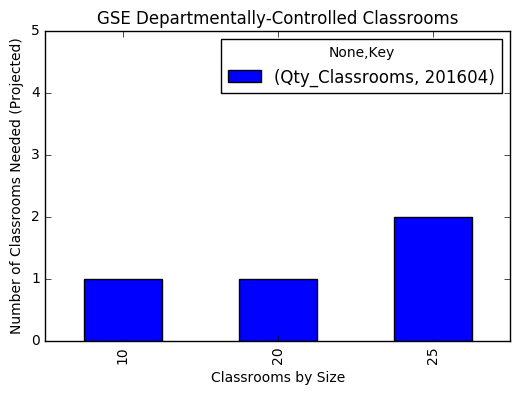

In [7]:
def filter_school(school_filter, term_filter):
    """
    Loads enrollment csv by term and gnerates a list of unique classes for that 
    department to check against the campus-wide classroom dataframe.
    """
    cls_filename = 'enrollment_data/CLE-{0}-{1}.csv'.format(school_filter, term_filter)
    df_classes = pd.read_csv(cls_filename)
    # Filter out PE classes
    df_classes = df_classes.loc[df_classes['Schedule_Type_Desc'] != 'Activity']
    df_classes['Class_'] = df_classes['Subj'] + " " + df_classes['Course'] 
    valid_class_list = set(df_classes['Class_'].tolist()) # Get only unique values
    return valid_class_list

def filter_dept_control_CPO_list(term_filter):
    """
    Special condition to check against CPO 2016 departmentally-owned classroom list
    """
    dc_filename = 'classroom_data/CPO_dc_list-{0}.csv'.format(term_filter)
    df_dept_control = pd.read_csv(dc_filename)    
    sh_filename = 'classroom_data/CPO_gp_share_list-{0}.csv'.format(term_filter)
    df_share = pd.read_csv(sh_filename)    
    df_dept = pd.concat([df_dept_control, df_share])
    df_dept['Classroom'] = df_dept['Building'] + ' ' + df_dept['ROOM'].astype(str)
    df_dept = df_dept[['Classroom', 'Dept']]
    df_dept.rename(columns={'Dept' : 'Dept_'}, inplace=True)
    print("== Using Internal CPO 2016 Departmentally-owned classroom information ==")
    return df_dept

def filter_dept_control_list(term_filter):
    dep_filename = 'classroom_data/dept_control_list-{0}.csv'.format(term_filter)
    df_dept = pd.read_csv(dep_filename)    
    df_dept['Classroom'] = df_dept["Room"] + " " + df_dept["Room.1"]
    print("== Using DATAMASTER Departmentally-owned classroom information ==") 
    return df_dept

def filter_AIM_dept_control_list(school_filter, term_filter):
    dep_filename = 'classroom_data/AIM-{0}-{1}.csv'.format(school_filter, term_filter)
    df_dept = pd.read_csv(dep_filename)    
    df_dept['Classroom'] = df_dept["acronym"] + " " +df_dept["location_code"]
    print("== Using AIM Departmentally-owned classroom information ==") 
    return df_dept

def filter_gp_classrooms(term_filter):
    dep_filename = 'classroom_data/GP-classrooms-{0}.csv'.format(term_filter)
    df_gp = pd.read_csv(dep_filename)    
    df_gp['Classroom'] = df_gp["Room"] + " " + df_gp["Room.1"]
    print("== Using DATAMASTER General Pool classroom information ==") 
    return df_gp   

def filter_all_classrooms(term_filter):
    """
    Loads datamaster table for ALL classrooms per scheduled term.
    """
    dep_filename = 'classroom_data/GP_DPT-classrooms-{0}.csv'.format(term_filter)
    df_all = pd.read_csv(dep_filename)    
    df_all['Classroom'] = df_all["Room"] + " " + df_all["Room.1"]
    print("== Using DATAMASTER 'All Classrooms' table S0019 ==")
    return df_all      

def filter_class_logic(school_filter, term_filter, classroom_filter, db_decision):
    """
    Controlling logic for filtering departmentally-owned, general pool, or ALL
    classroom types. 
    """
    if classroom_filter == 'DO':
        if db_decision == 'DATAMASTER': 
            df_dept = filter_dept_control_list(term_filter)
            return df_dept
        elif db_decision == 'CPO':
            CPO_dept_owned = filter_dept_control_CPO_list(term_filter)
            return CPO_dept_owned
        elif db_decision == 'AIM':
            AIM_dept_owned = filter_AIM_dept_control_list(school_filter, term_filter)
            return AIM_dept_owned
        else: 
            print('ERROR: Invalid input!')
    if classroom_filter == 'GP':
        gp_class = filter_gp_classrooms(term_filter)
        return gp_class
    if classroom_filter == 'ALL':    
        all_class = filter_all_classrooms(term_filter)
        return all_class

def format_date(df_date):
    """
    Splits Meeting times into Days of the week, Start time, and End time using regex
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('^(.*?)-', expand=True)
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('((?<=-).*$)', expand=True)
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

def format_df_reg(df_reg):
    df_reg = df_reg.loc[df_reg['Xlst'] == '']
    columns = ['ROOM', 'Actual_Enrl', 'Room_Capacity', 'Weekly_Class_Hours']
    df_reg = df_reg[columns]
    df_reg['%_Capacity'] = df_reg['Actual_Enrl'] / df_reg['Room_Capacity'].astype(int)
    return df_reg

def merge_xlist(df_xl):
    """
    Merges courses with a value in Xlist column. Sums Actual_Enrl for totals 
    column but retains Room Number, Room Capacity, and Weekly Class Hours, as 
    these numbers are constant. 
    """
    df_xl = df_xl.loc[df_xl['Xlst'] != '']
    xl_operations = ({'ROOM' : 'max',
                      'Actual_Enrl' : 'sum', 
                      'Room_Capacity' : 'max',
                      'Weekly_Class_Hours' : 'max',})
    df_xl = df_xl.groupby('Xlst', as_index=False).agg(xl_operations)
    df_xl['%_Capacity'] = df_xl['Actual_Enrl'] / df_xl['Room_Capacity'].astype(int)
    return df_xl

def aggregate(df_agg):
    """
    Main aggegation function of PSU classrooms. Inputs unified dataframe of 
    crosslisted and non-crosslisted courses. Sums Weekly_Class_Hours and 
    calculates mean of Room_Capacity and Actual_Enrl.

    Performs Optimal 125% Size calculation.
    """
    df_agg['Room_Capacity'] = df_agg['Room_Capacity'].astype(float)
    df_agg['Actual_Enrl'] = df_agg['Actual_Enrl'].astype(float)

    operations = ({'Weekly_Class_Hours' : 'sum', 
                   'Room_Capacity' : 'mean', 
                   'Actual_Enrl' : 'mean',})
    df_agg = df_agg.groupby('ROOM', as_index=False).agg(operations)

    # Calculate hourly utilizations
    df_agg['Class_Hour_Utilization'] = (df_agg['Weekly_Class_Hours']/40.0).astype(float)

    # Round optimal size to the nearest 5
    df_agg['Optimal_Size'] = 5 * round((df_agg['Actual_Enrl'] * 1.25)/5)
    # Optimal size should be a minimum of 10 seats
    df_agg.loc[df_agg['Optimal_Size'] < 10.0, 'Optimal_Size'] = 10.0
    # 'Bin' figures to fixed ranges. From Ernest Tipton's 201604 Spreadsheet.
    df_agg.loc[(df_agg['Optimal_Size'] > 60.0) & (df_agg['Optimal_Size'] < 75.0), 'Optimal_Size'] = 75.0
    df_agg.loc[(df_agg['Optimal_Size'] > 75.0) & (df_agg['Optimal_Size'] < 80.0), 'Optimal_Size'] = 80.0
    df_agg.loc[(df_agg['Optimal_Size'] > 80.0) & (df_agg['Optimal_Size'] < 100.0), 'Optimal_Size'] = 100.0
    df_agg.loc[(df_agg['Optimal_Size'] > 100.0) & (df_agg['Optimal_Size'] < 150.0), 'Optimal_Size'] = 150.0
    df_agg.loc[(df_agg['Optimal_Size'] > 150.0) & (df_agg['Optimal_Size'] < 200.0), 'Optimal_Size'] = 200.0
    df_agg.loc[(df_agg['Optimal_Size'] > 200.0) & (df_agg['Optimal_Size'] < 220.0), 'Optimal_Size'] = 220.0  
    df_agg.loc[(df_agg['Optimal_Size'] > 220.0) & (df_agg['Optimal_Size'] < 380.0), 'Optimal_Size'] = 380.0
    return df_agg

def right_sizing(df_rs):
    growth_factor = 0.01 * 3 # 1% annual growth over three years
    rs_operations = ({'Class_Hour_Utilization' : 'sum'})
    df_rs = df_rs.groupby('Optimal_Size', as_index=False).agg(rs_operations)
    df_rs['Calibrated_Demand'] = df_rs['Class_Hour_Utilization'] + growth_factor
    # Round up to the nearest integer
    df_rs['Qty_Classrooms'] = np.ceil(df_rs['Calibrated_Demand'])
    df_rs['Qty_Seats'] = df_rs['Optimal_Size'] * df_rs['Qty_Classrooms']
    df_rs = df_rs.drop('Class_Hour_Utilization', 1) #Simplify formatting for printing
    return df_rs

def final_print(df_print, school_print, term_print):
    print('===================================================================')
    print('Report for {0} - {1}'.format(school_print, term_print))
    print(df_print)
    print("Total Number of Classrooms Needed (Projected): ", df_print['Qty_Classrooms'].sum())
    print("Total Number of Seats Needed (Projected): ", df_print['Qty_Seats'].sum())
    print('===================================================================','\n')
    columns = ['Optimal_Size', 'Key', 'Qty_Classrooms']
    df_print['Key'] = term_print
    df_print['Optimal_Size'] = df_print['Optimal_Size'].astype(int)
    df_print = df_print[columns]
    return df_print

def plot_graphs(df_grph_lst, school_print, class_type_print):
    """
    Takes a list of dfs per term and plots them in a single figure.
    """
    class_dct = ({'DO' : 'Departmentally-Controlled Classrooms',
                  'GP' : 'General Pool Classrooms',
                  'ALL': 'Dept-Controlled and General Pool Classrooms'})
    df_all = pd.concat(df_grph_lst)
    df_group = df_all.groupby(['Optimal_Size', 'Key'])
    df_group_plot = df_group.sum().unstack('Key').plot(kind='bar')
    df_group_plot.set_xlabel('Classrooms by Size')
    df_group_plot.set_ylabel('Number of Classrooms Needed (Projected)')
    df_group_plot.set_title('{0} {1}'.format(school_print, class_dct[class_type_print]))
    df_group_plot.set_ylim([0, 5]) #Departmental view 
    #df_group_plot.set_ylim([0, 75]) # Uncomment for FULL CAMPUS VIEW
    plt.show()

def input_flow():
    """
    Captures main User prompts and inputs
    """
    #terms = ['201604', '201504', '201404', '201304']
    terms = ['201604']
    school = input("Enter desired department for evaluation: GSE or SPH >>> ").upper()
    inp_classroom_type = input("Filter by Departmentally-Owned, General Pool, or ALL Classrooms? DO/GP/ALL >>> ").upper()
    if inp_classroom_type == 'DO':
        inp_db = input("Choose department ownership by database: CPO/AIM/DATAMASTER >>> ").upper()
        if inp_db == 'CPO' or inp_db == 'AIM':
            terms = ['201604']
    else:
        inp_db = ""
    return terms, school, inp_classroom_type, inp_db

def main():
    """
    Main program control flow.
    """
    terms, school, inp_classroom_type, inp_db = input_flow()
    graph_dfs = []

    for term in terms:
        df = pd.read_csv('classroom_data/PSU_master_classroom.csv')
        df = df.fillna('')
        df = df[df['Term'] == int(term)]

        ### Comment out this block for General PSU Campus snapshot
        classes_to_check = filter_school(school, term)
        df = df.loc[df['Class'].isin(classes_to_check)]
        df_class = filter_class_logic(school, term, inp_classroom_type, inp_db)
        df = pd.merge(df, df_class, left_on=df['ROOM'], right_on=df_class['Classroom'], how='inner')
        ###

        # Avoid key error when printing
        if 'Dept' in df: 
            df.rename(columns={'Dept' : 'Dept_'}, inplace=True)
        
        df = format_date(df)
        # Avoid classes that only occur on a single day
        df = df.loc[df['Start_Date'] != df['End_Date']]

        # Calculate number of days per week and treat Sunday condition
        if 'SU' not in df['Days']:
            df['Days_Per_Week'] = df['Days'].str.len()
        else:
            print('Sunday Condition!')
            #ToDO: If sunday does come up, refactor code to address this.

        df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
        df['%_Capacity'] = df['Actual_Enrl'].astype(int) / df['Room_Capacity'].astype(int) 
        df['Actual_Enrl'] = df['Actual_Enrl'].astype(int)
        df['Weekly_Class_Hours'] = df['Duration_Hr'] * df['Days_Per_Week']

        print('Raw Class list dump:')
        print(df[['ROOM', 'Room_Capacity', 'Dept_', 'Class', 'Xlst', 'Actual_Enrl']])

        # split df into crosslisted and non-crosslisted classes and send them to
        # respective functions for cleaning
        df_reg = format_df_reg(df)
        df_xlist = merge_xlist(df)
        # Recombine into one dataframe
        df_combined = aggregate(pd.concat([df_reg, df_xlist]))
        
        df_final = right_sizing(df_combined)
        df_graph = final_print(df_final, school, term)
        graph_dfs.append(df_graph)

    plot_graphs(graph_dfs, school, inp_classroom_type)
   
if __name__=='__main__':
    main()            #ToDO: If sunday does come up, refactor code to address this.